# Variational Autoencoder

## Imports

In [1]:
# Grab the keras version packaged with tf, because apparently that is the new way of doing this
# I'm using TF 2.1.0
from tensorflow import keras

# Imports from keras
from keras import Input
from keras.models import Model # Functional API
from keras.layers import Dense, Lambda
import keras.backend as K
from keras.utils import plot_model
from keras.losses import mse

Using TensorFlow backend.


## Preprocessing

In [2]:
# Alejandro write code here
# Data needs to be (samples,num_features)
# I put numu_features as 513
# Split the data into a training batch and a validation batch
# I'm expecting the variables x_train and x_test

## Model Setup

### Utility functions to build each section

In [3]:
# Reparameterization trick to push the N(0,1) into the back prop inputs
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# Encoder
def build_encoder(original_dim,intermediate_dim,activation,latent_dim):
    encoder_inputs = Input(shape=(original_dim,), name='encoder_inputs')
    # MLP into μ and logσ
    x = Dense(intermediate_dim, activation=activation)(encoder_inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # Sample from the distrubtion to get a z
    z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder') # Include all of the outputs

In [5]:
# Decoder
def build_decoder(original_dim,intermediate_dim,activation,latent_dim):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation=activation)(latent_inputs)
    outputs = Dense(original_dim, activation='tanh')(x)
    return Model(latent_inputs,outputs,name='decoder')

### Define model parameters and construct the model

In [6]:
# Model Parameters
original_dim = 513
intermediate_dim = 128
latent_dim = 32
activations = 'relu'

# Construct the model
inputs = Input(shape=(original_dim,), name='model_input')
encoder = build_encoder(original_dim,intermediate_dim,activations,latent_dim)
decoder = build_decoder(original_dim,intermediate_dim,activations,latent_dim)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [7]:
# Setup cost functions
def loss(inputs,encoder,decoder,original_dim):
    z_mean,z_log_var,z = encoder(inputs)
    outputs = decoder(z)
    reconstruction_loss = mse(inputs,outputs) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
    return K.mean(reconstruction_loss + kl_loss)
    
vae.add_loss(loss(inputs,encoder,decoder,original_dim))

In [8]:
# Finally, compile the model!
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 513)               0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  74048     
_________________________________________________________________
decoder (Model)              (None, 513)               70401     
Total params: 144,449
Trainable params: 144,449
Non-trainable params: 0
_________________________________________________________________


/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


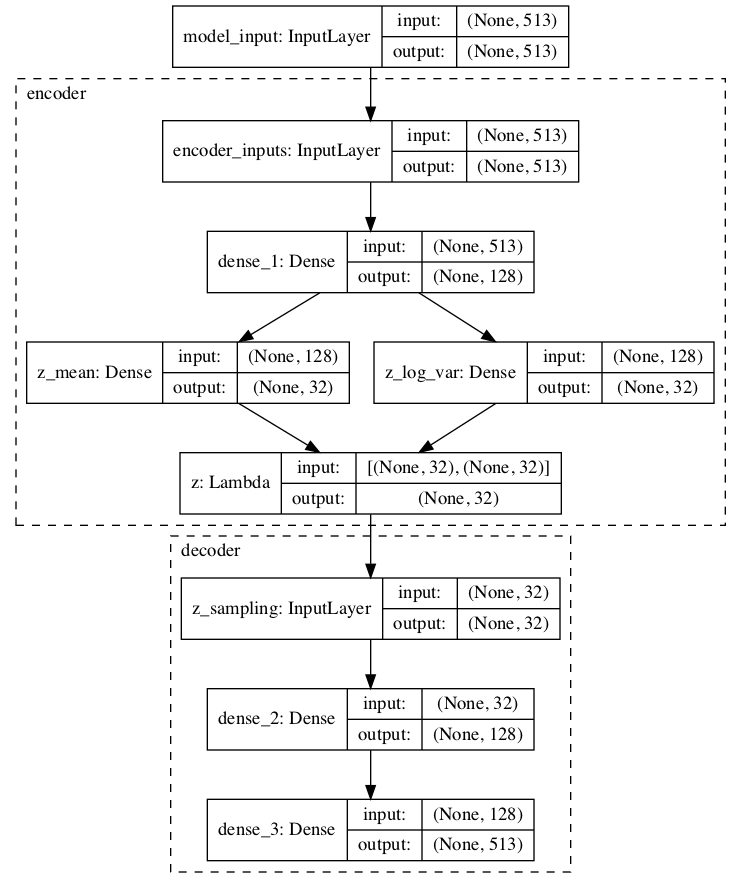

In [9]:
# Draw it, why not
plot_model(vae, show_shapes=True,expand_nested=True)

## Training Setup

In [21]:
# Epochs and batch size
epochs = 50
batch_size = 128

# Train boi
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))

NameError: name 'x_train' is not defined

## Postprocessing

In [23]:
# Alejandro write code here
# We need a wav file as the output?